## TUTORIAL 01 - Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-10)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(10)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

29900 1.585191403671664e-06 	Loss(validation) = 2.858352512632555e-05
30000 9.924709200205935e-06 	Loss(validation) = 3.431911601675528e-05
30100 1.305712351304045e-06 	Loss(validation) = 2.7776309555602847e-05
30200 1.8220276002414987e-06 	Loss(validation) = 2.843944593691434e-05
30300 1.2887499422729078e-06 	Loss(validation) = 2.7427108195180463e-05
30400 4.660723812178841e-05 	Loss(validation) = 8.09937826861946e-05
30500 1.2735008194572759e-06 	Loss(validation) = 2.720796321336045e-05
30600 1.2642643291379169e-06 	Loss(validation) = 2.6952762337551015e-05
30700 4.177139493159236e-06 	Loss(validation) = 3.6079538256859126e-05
30800 1.2493192755101838e-06 	Loss(validation) = 2.6674967213016847e-05
30900 1.2412331412958999e-06 	Loss(validation) = 2.645623233837068e-05
31000 1.2808300955282463e-06 	Loss(validation) = 2.621240608343822e-05
31100 1.2258094627819927e-06 	Loss(validation) = 2.6169301549131056e-05
31200 0.00025517690168962214 	Loss(validation) = 0.0004028891382560759
31300 

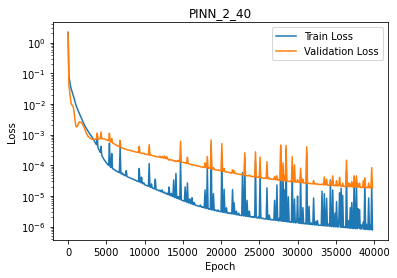

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

In [60]:
A = pinn_loss.operators['a'].detach().numpy()
np.mean(np.trace(np.transpose(A, axes=(0, 2, 1)) @ A, axis1=1, axis2=2) / 4)

8.669322297219455

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [22]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=3000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [23]:
pdnn_trainer.train()

300 0.00202637448023782 	Loss(validation) = 0.06439205192548868
400 0.0002878692893024562 	Loss(validation) = 0.07721753073001203
500 0.00016367729857954811 	Loss(validation) = 0.07916251084126316
600 0.0001082444860842698 	Loss(validation) = 0.0791994956868909
700 6.94483076863594e-05 	Loss(validation) = 0.07904061118737221
800 4.282451278418656e-05 	Loss(validation) = 0.07889734367319089
900 2.53309374489302e-05 	Loss(validation) = 0.07876492035063408
1000 1.4343361824213335e-05 	Loss(validation) = 0.07863030155781822
1100 7.755681636105945e-06 	Loss(validation) = 0.07849396571463003
1200 3.993712036793498e-06 	Loss(validation) = 0.07836381366189633
1300 1.9532471145280067e-06 	Loss(validation) = 0.07824792237548595
1400 9.049845166078536e-07 	Loss(validation) = 0.07815137012976482
1500 3.963683329633638e-07 	Loss(validation) = 0.07807569709279737
1600 1.6369270609801953e-07 	Loss(validation) = 0.07801948928913155
1700 6.361035475616663e-08 	Loss(validation) = 0.07797961565398497
180

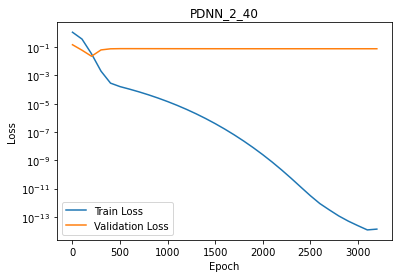

In [24]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [66]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 8.669322297219455
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=1)#100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [67]:
prnn_trainer.train()

0 7.038840608623753
100 2.959363775645786
200 0.9603287335398372
300 0.22208588134354315
400 0.0372794961130524
500 0.003271367562692484
600 0.0002336153904750871
700 5.404491714969381e-05
800 3.6252244687541216e-05
900 3.385669257402611e-05
1000 3.356640826392155e-05
1100 3.3530078062494734e-05
1200 3.351781135258499e-05
1300 3.350677166884708e-05
1400 3.349505713322734e-05
1500 3.348256619120147e-05
1600 3.346927262265754e-05
1700 3.345513848300556e-05
1800 3.3440163735721885e-05
1900 3.342428337518501e-05
2000 3.340744809690771e-05
2100 3.338964613400951e-05
2200 3.3370869520434496e-05
2300 3.3351043465598884e-05
2400 3.333009288897707e-05
2500 3.330802487540852e-05
2600 3.3284775404831755e-05
2700 3.3260300384188894e-05
2800 3.32345544494276e-05
2900 3.32074648238732e-05
3000 3.3178975134065726e-05
3100 3.314898927774386e-05
3200 3.311751078281676e-05
3300 3.308446679147108e-05
3400 3.304974881797217e-05
3500 3.301330605519855e-05
3600 0.00016003684658188867
3700 3.293792499390697e

29300 1.549691394606296e-05
29400 1.9597860478574508e-05
29500 3.340203486921151e-05
29600 1.6127089895641014e-05
29700 1.8659168537628412e-05
29800 3.0215845132378262e-05
29900 5.150457664009493e-05
30000 1.959075294789557e-05
30100 1.6083099470937104e-05
30200 6.345566836891454e-05
30300 1.6091778577741936e-05
30400 1.5233693845754829e-05
30500 1.7237444085906372e-05
30600 1.9980342186423994e-05
30700 2.6860645276970847e-05
30800 1.5280334425536433e-05
30900 3.113780921498715e-05
31000 2.1667280950973445e-05
31100 1.785624651066857e-05
31200 1.915966201978104e-05
31300 1.5002318542067179e-05
31400 2.1650203430731012e-05
31500 1.552043377774827e-05
31600 6.245278249685811e-05
31700 1.6582628117189088e-05
31800 2.194659184219286e-05
31900 3.9654372944943e-05
32000 3.0504480019278942e-05
32100 6.797799003679867e-05
32200 1.7506630966169983e-05
32300 1.408002184917389e-05
32400 1.5177034438348661e-05
32500 1.9936875487593195e-05
32600 1.650253869120135e-05
32700 1.7923649450386452e-05
32

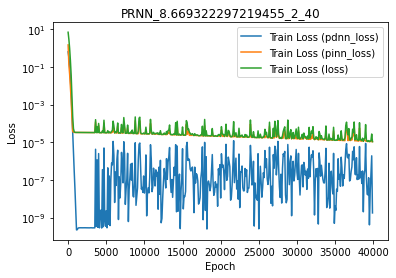

In [68]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [40]:
reduction_method.initialize_testing_set(100)
#reduction_method.error_analysis()

False

#### 4.6.2 PINN Error Analysis

In [41]:
#test_mu = torch.tensor(reduction_method.testing_set)
test_mu = data.train_data_no_snaps#torch.tensor(reduction_method.training_set)

In [43]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	7.15096893394435e-05	7.150683462642147e-05	4.1179454431958455e-07
mean	0.004060950304590483	0.004060950055744394	6.267269765320966e-07
max	0.09157360749280959	0.09157360915272272	1.8462820012419785e-06


In [ ]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (8.0, -1.0), input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (8.0, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [69]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.20087355605187154	0.20087355500643456	4.1179454431958455e-07
mean	8.973210601236158	8.973210607265042	6.267269765320966e-07
max	458.9615103087711	458.9615105848353	1.8462820012419785e-06


In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (8.0, -1.0), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()